TMH Metrics (filename: (TMH, posTMH, negTMH)):
Pitt_0050058_network.graphml: (199.0, 97.93499948575543, 102.44354917952245)
Pitt_0050060_network.graphml: (199.0, 97.93132604660755, 102.92432856302686)
SBL_0051557_network.graphml: (199.0, 95.26842160904958, 105.02461450052677)
SBL_0051558_network.graphml: (199.0, 92.05834963747267, 116.11568994737311)
SBL_0051559_network.graphml: (199.0, 95.33350979354155, 105.3481587757054)
SBL_0051560_network.graphml: (199.0, 95.37073067568997, 105.1551278368285)
Trinity_0050259_network.graphml: (199.0, 97.37777777777778, 104.56965584100824)
Trinity_0050260_network.graphml: (199.0, 97.3366121350176, 103.13347002538566)
Trinity_0050261_network.graphml: (199.0, 98.13107996702391, 102.99843075715967)
Trinity_0050262_network.graphml: (199.0, 98.81803194229778, 103.6330554193232)
Trinity_0050263_network.graphml: (199.0, 97.23681210488134, 103.21295483367476)
Trinity_0050264_network.graphml: (199.0, 100.6308063543133, 100.70986538075145)
Trinity_0050267_net

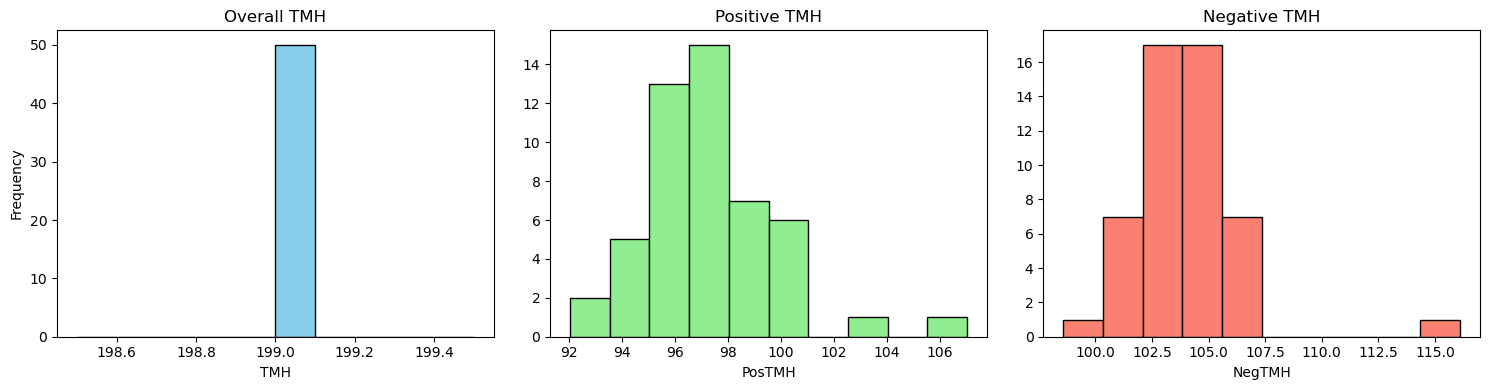

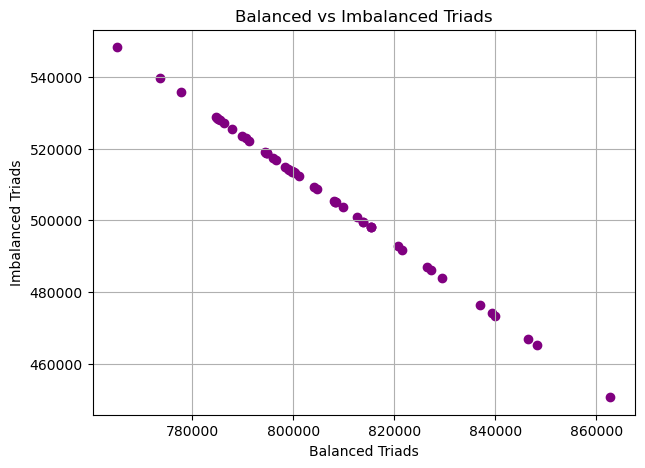

C:\Users\Saeed\AppData\Local\Temp\ipykernel_12952\1669437258.py:172: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=["Balanced", "Imbalanced"])


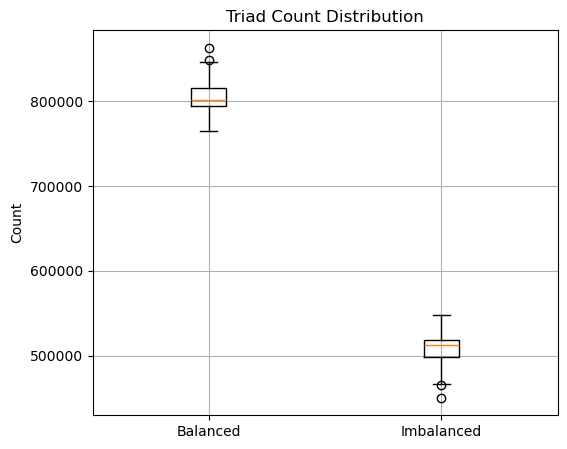

In [1]:
import os
import glob
import itertools
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

########################################
# 1. Helper Functions
########################################

def update_edge_signs(G):
    """
    For each edge in G, add/update the 'sign' attribute.
    sign is set to +1 if the weight is >= 0, and -1 otherwise.
    """
    for u, v, data in G.edges(data=True):
        try:
            weight = float(data.get('weight', 0))
        except ValueError:
            weight = 0.0
        data['sign'] = 1 if weight >= 0 else -1
    return G

def compute_TMH(G):
    """
    Compute Tendency to Make Hub (TMH) metrics:
      - Overall TMH = (Σ D_i^2) / (Σ D_i)
      - Positive TMH (PosTMH) computed from edges with sign +1.
      - Negative TMH (NegTMH) computed from edges with sign -1.
    """
    # Overall degrees
    degrees = np.array([d for n, d in G.degree()])
    TMH = np.sum(degrees**2) / np.sum(degrees) if np.sum(degrees) > 0 else np.nan

    # Compute positive and negative degrees per node
    pos_degrees = {n: 0 for n in G.nodes()}
    neg_degrees = {n: 0 for n in G.nodes()}
    for u, v, data in G.edges(data=True):
        sign = data.get('sign', 1)
        if sign == 1:
            pos_degrees[u] += 1
            pos_degrees[v] += 1
        else:
            neg_degrees[u] += 1
            neg_degrees[v] += 1

    pos_deg_arr = np.array(list(pos_degrees.values()))
    neg_deg_arr = np.array(list(neg_degrees.values()))
    posTMH = np.sum(pos_deg_arr**2) / np.sum(pos_deg_arr) if np.sum(pos_deg_arr) > 0 else np.nan
    negTMH = np.sum(neg_deg_arr**2) / np.sum(neg_deg_arr) if np.sum(neg_deg_arr) > 0 else np.nan

    return TMH, posTMH, negTMH

def compute_triad_counts(G):
    """
    Compute the number of balanced and imbalanced triads in G.
    For every triple of nodes that forms a triangle, the triad is:
      - Balanced if the product of the signs is +1.
      - Imbalanced if the product is -1.
    Only complete triads (all three edges exist) are considered.
    """
    balanced = 0
    imbalanced = 0
    nodes = list(G.nodes())
    for triad in itertools.combinations(nodes, 3):
        u, v, w = triad
        if G.has_edge(u, v) and G.has_edge(u, w) and G.has_edge(v, w):
            sign_uv = G[u][v].get('sign', 1)
            sign_uw = G[u][w].get('sign', 1)
            sign_vw = G[v][w].get('sign', 1)
            product = sign_uv * sign_uw * sign_vw
            if product == 1:
                balanced += 1
            elif product == -1:
                imbalanced += 1
    return balanced, imbalanced

########################################
# 2. Analysis on a Collection of Networks
########################################

def analyze_networks(network_dir):
    """
    For all .graphml files in network_dir, load each network, update edge signs,
    compute TMH metrics and triad counts.
    Returns dictionaries of the metrics keyed by filename.
    """
    network_files = glob.glob(os.path.join(network_dir, "*.graphml"))
    if not network_files:
        print(f"No network files found in {network_dir}")
        return {}, {}, {}

    tmh_results = {}      # filename: (TMH, posTMH, negTMH)
    triad_results = {}    # filename: (balanced, imbalanced)
    
    for net_file in network_files:
        G = nx.read_graphml(net_file)
        G = update_edge_signs(G)
        
        # Compute TMH metrics
        TMH, posTMH, negTMH = compute_TMH(G)
        tmh_results[os.path.basename(net_file)] = (TMH, posTMH, negTMH)
        
        # Compute triad counts
        balanced, imbalanced = compute_triad_counts(G)
        triad_results[os.path.basename(net_file)] = (balanced, imbalanced)
    
    return tmh_results, triad_results

########################################
# 3. Visualization Functions
########################################

def plot_TMH_histograms(tmh_results):
    """
    Plot histograms for overall TMH, positive TMH, and negative TMH.
    """
    overall = []
    pos = []
    neg = []
    for metrics in tmh_results.values():
        overall.append(metrics[0])
        pos.append(metrics[1])
        neg.append(metrics[2])
    
    plt.figure(figsize=(15, 4))
    
    plt.subplot(1, 3, 1)
    plt.hist(overall, bins=10, color='skyblue', edgecolor='black')
    plt.title("Overall TMH")
    plt.xlabel("TMH")
    plt.ylabel("Frequency")
    
    plt.subplot(1, 3, 2)
    plt.hist(pos, bins=10, color='lightgreen', edgecolor='black')
    plt.title("Positive TMH")
    plt.xlabel("PosTMH")
    
    plt.subplot(1, 3, 3)
    plt.hist(neg, bins=10, color='salmon', edgecolor='black')
    plt.title("Negative TMH")
    plt.xlabel("NegTMH")
    
    plt.tight_layout()
    plt.show()

def plot_triad_counts(triad_results):
    """
    Plot a scatter plot and boxplot for balanced and imbalanced triad counts.
    """
    balanced = []
    imbalanced = []
    labels = []
    for fname, counts in triad_results.items():
        balanced.append(counts[0])
        imbalanced.append(counts[1])
        labels.append(fname)
    
    # Scatter plot
    plt.figure(figsize=(7, 5))
    plt.scatter(balanced, imbalanced, color='purple')
    plt.xlabel("Balanced Triads")
    plt.ylabel("Imbalanced Triads")
    plt.title("Balanced vs Imbalanced Triads")
    plt.grid(True)
    plt.show()
    
    # Boxplot comparison
    plt.figure(figsize=(6, 5))
    data_to_plot = [balanced, imbalanced]
    plt.boxplot(data_to_plot, labels=["Balanced", "Imbalanced"])
    plt.ylabel("Count")
    plt.title("Triad Count Distribution")
    plt.grid(True)
    plt.show()

########################################
# 4. Main Function
########################################

def main():
    # Update the directory to where your .graphml files are stored.
    network_dir = r"D:\Project_001\NETWORK_FINAL\ControlNetworks"  # Change this as needed

    tmh_results, triad_results = analyze_networks(network_dir)
    
    if not tmh_results:
        print("No networks analyzed.")
        return

    # Print computed metrics for inspection
    print("TMH Metrics (filename: (TMH, posTMH, negTMH)):")
    for fname, metrics in tmh_results.items():
        print(f"{fname}: {metrics}")
        
    print("\nTriad Counts (filename: (balanced, imbalanced)):")
    for fname, counts in triad_results.items():
        print(f"{fname}: {counts}")
    
    # Visualize TMH metrics
    plot_TMH_histograms(tmh_results)
    
    # Visualize triad counts
    plot_triad_counts(triad_results)

if __name__ == "__main__":
    main()
